# About

The initial analysis performed by the community members revealed that the feature calc has the highest impact on predicting the existence of kidney stones. In this analysis, we aim to investigate the relationship between the residual values of predictions made solely based on calc and the other features in the dataset. 

Specifically, we are interested in exploring whether incorporating other features can improve the accuracy of predictions made based on calc.

In this notebook we created a predictor based on the prior calc -> target probability, and analyzed the relation between the residuals and the other variables in the dataset.

# Setuping and importing libraries

In [1]:
!pip install pycaret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.8/481.8 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.4/256.4 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 kB 4.6 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - \ | / - \ done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 kB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 53.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 54.1 MB/s eta 0:00:00
  Using cached importlib_metadata-6.4.1-py3-none-any.whl (22 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 4.0 MB/s et

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import pycaret.regression as pc
from sklearn.model_selection import KFold

In [3]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s3e12/sample_submission.csv
/kaggle/input/playground-series-s3e12/train.csv
/kaggle/input/playground-series-s3e12/test.csv


In [4]:
df = pd.read_csv('/kaggle/input/playground-series-s3e12/train.csv').drop('id', axis = 1)

In [5]:
palette = sns.color_palette('gray')
sns.set_palette(palette)
seed = 42

# Data profiling

We will start this study profiling the dataset for those who are not familiar with it.

We can highlight some information regarding the provided data:

The dataset is relatively small, containing 414 samples and 6 features.

- There are no missing values

- The target dataset is slightly unbalanced (66% = 0, 44% = 1)

- Gravity, Osmo and Cond distributions are left skewed

- Calc and PH distributions are high skewed

- There are few Gravity and PH outliers in the training set

In [6]:
df.describe(percentiles=[.05, .5, .95])

,gravity,ph,osmo,cond,urea,calc,target
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,1.017894,5.955459,651.545894,21.437923,278.657005,4.114638,0.444444
std,0.006675,0.642260,234.676567,7.514750,136.442249,3.217641,0.497505
min,1.005000,4.760000,187.000000,5.100000,10.000000,0.170000,0.000000
5%,1.008000,5.210000,253.000000,8.800000,75.000000,0.810000,0.000000
50%,1.018000,5.740000,679.500000,22.200000,277.000000,3.130000,0.000000
95%,1.028000,7.235000,1032.000000,32.950000,516.000000,9.390000,1.000000
max,1.040000,7.940000,1236.000000,38.000000,620.000000,14.340000,1.000000


In [7]:
df.isna().sum()

gravity    0
ph         0
osmo       0
cond       0
urea       0
calc       0
target     0
dtype: int64

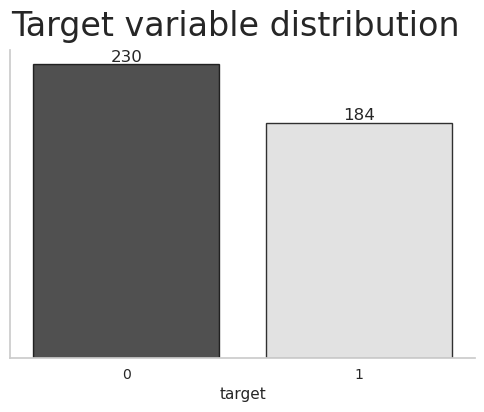

In [8]:
fig = plt.figure(figsize = (6,4))

ax = sns.countplot(x = df['target'], linewidth = 1, edgecolor = 'black', alpha = .8,
                  palette = [palette[0], palette[-1]])
for i in ax.containers:
    ax.bar_label(i,)

fig.suptitle('Target variable distribution\n', fontsize = 24)

ax.set_ylabel('')

plt.yticks([])
sns.despine()
plt.show()

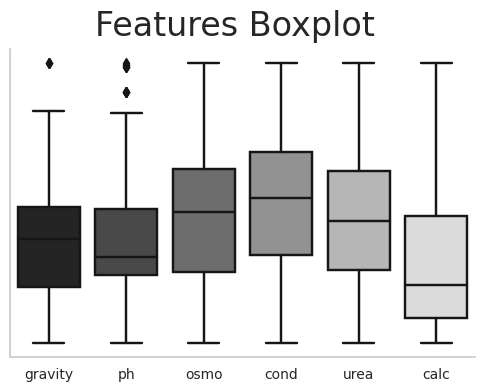

In [9]:
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

fig = plt.figure(figsize = (6,4))

fig.suptitle('Features Boxplot', fontsize = 24)
ax = sns.boxplot(data=df_scaled.drop('target', axis = 1))
plt.yticks([])
sns.despine()
plt.show()

# Exploratory data analysis

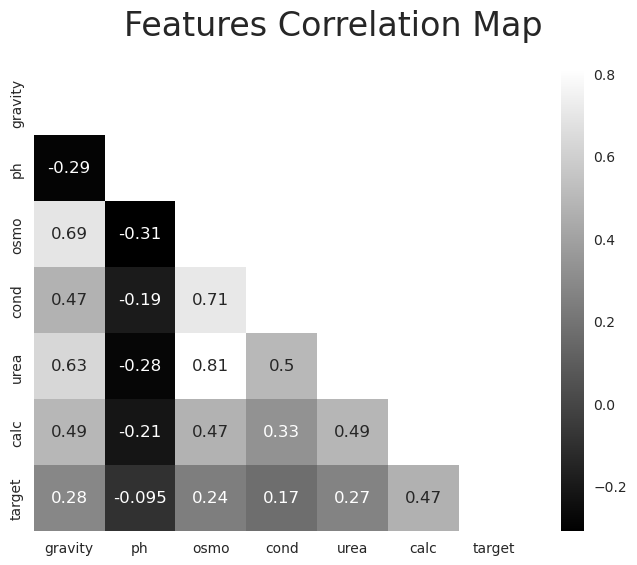

In [10]:
corr = df.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

fig = plt.figure(figsize = (8,6))
fig.suptitle('Features Correlation Map', fontsize = 24)
sns.heatmap(corr, mask=mask, annot=True, cmap = 'gray')
plt.show()

- Some features are highly correlated which is generally undesirable, highly correlated features tend to be redundant.
- Calc has a fair correlation with the target.

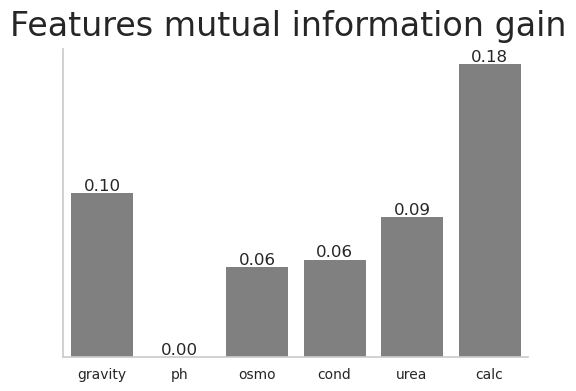

In [11]:
mutual_info = mutual_info_classif(df.drop('target', axis=1), df['target'])

fig = plt.figure(figsize = (6,4))

ax = sns.barplot(x=df.drop('target', axis=1).columns, y=mutual_info, color = 'grey')

for i in ax.containers:
    ax.bar_label(i,fmt='%.2f')

fig.suptitle('Features mutual information gain\n', fontsize = 24)

plt.yticks([])
sns.despine()
plt.show()

Mutual information is a metric to measure how much a given feature can reduce the entropy of the target variable samples, this concept is widely used in tree based models to select the tree splitting features.

- Once again calc leads the potential predictive power indicator.

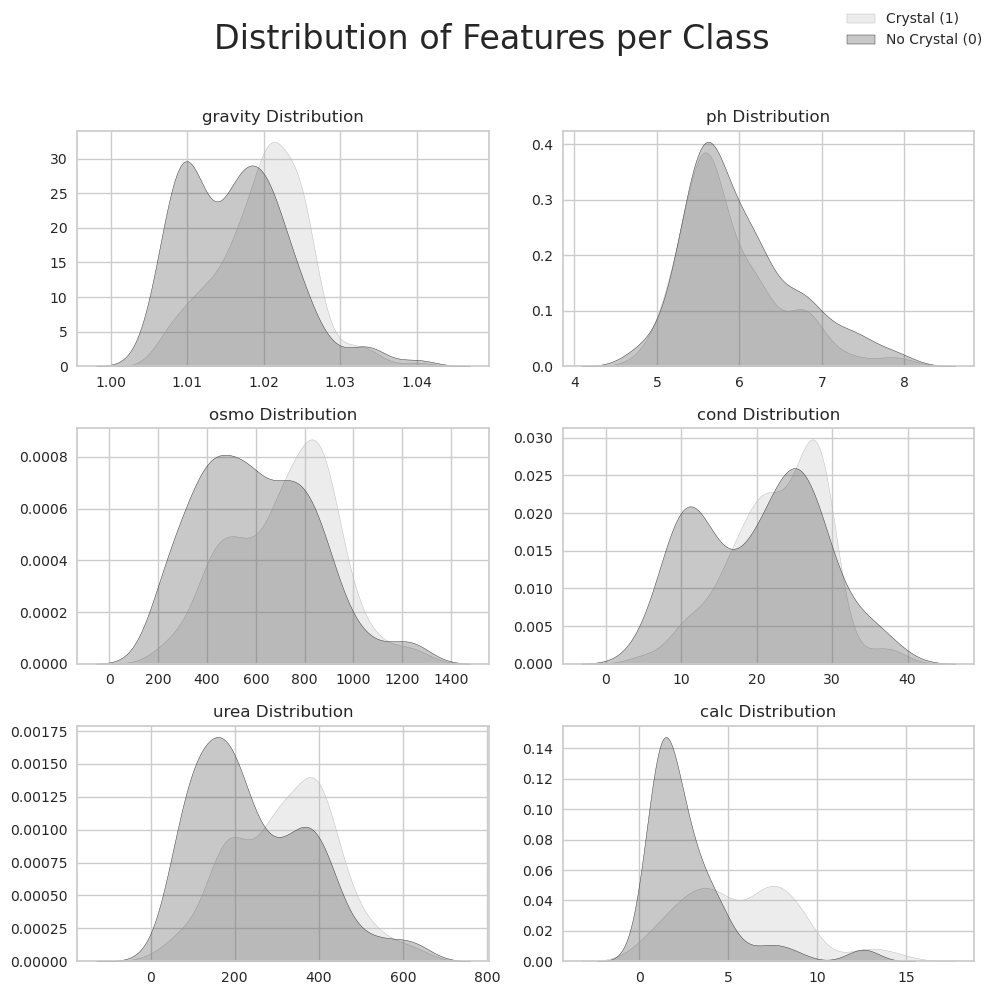

In [12]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))
ax = ax.flatten()

for i, col in enumerate(['gravity', 'ph', 'osmo', 'cond', 'urea', 'calc']):
    sns.kdeplot(data = df, x = col, ax=ax[i], fill = True, legend = False, 
                hue = 'target', palette = [palette[0], palette[-2]])
    
    ax[i].set_title(f'{col} Distribution')
    ax[i].set_xlabel(None)
    ax[i].set_ylabel(None)
    
fig.suptitle('Distribution of Features per Class\n', fontsize = 24)
fig.legend(['Crystal (1)', 'No Crystal (0)'])
plt.tight_layout()
plt.show()

- The calc distribution is different among the targets which in theory can provide a good predictive power.
- For the other features (except for PH) the target classes distributions are fairly separable what can somehow help classifying the samples.

# Modeling I

To evaluate the effectiveness of calc in the task of predicting the target we created a simple statistical model that works as following: 

1. Split the calc values into 0.1 intervals
2. Calculate the target probability for each interval
3. Apply the rolling mean function to smooth the results and reduce variance and overfitting.
4. Calculate the target probability of unseen samples based on the prior probability observed in the training set.

In [13]:
def calc_predictor_prob(df, target):
    df_copy = df.copy()
    df_copy['target'] = target
    
    df_copy['calc_bin'] = df_copy['calc'].round(1)
    intervals = df_copy['calc_bin'].nunique()
    
    calc_prob = df_copy.groupby('calc_bin').agg(prob=('target', 'mean'))
    calc_prob['smoothed_prob'] = calc_prob['prob'].rolling(7).mean()
    calc_prob['smoothed_prob'] = calc_prob['smoothed_prob'].fillna(method='bfill')

    probability_dict = calc_prob['smoothed_prob'].to_dict()    
    
    return probability_dict

In [14]:
X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = seed)

In [15]:
probability_table = calc_predictor_prob(X_train, y_train)

X_train['calc_predictor_prob'] = X_train['calc'].round(1).replace(probability_table)
X_train['calc_residue'] = X_train['calc_predictor_prob'] - y_train

X_test['calc_predictor_prob'] = X_test['calc'].round(1).replace(probability_table)
X_test['calc_residue'] = X_test['calc_predictor_prob'] - y_test

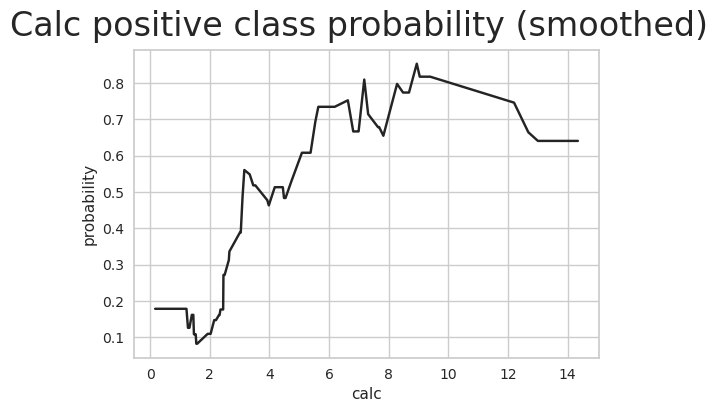

In [16]:
fig = plt.figure(figsize = (6,4))

ax = sns.lineplot(data = X_train, x = 'calc', y = 'calc_predictor_prob')

fig.suptitle('Calc positive class probability (smoothed)\n', fontsize = 24)

ax.set_ylabel('probability')
ax.set_xlabel('calc')
ax.grid(True)
plt.show()

The calc -> probability curves resembles the log function, the higher the value of calc the higher the kidney stone probability.

In [17]:
cv = KFold(n_splits= 10, shuffle = True, random_state = seed) 
roc_auc_list = []

for train_index, test_index in cv.split(X_train):
    
    X_tr, X_val = X_train.iloc[train_index], X_train.iloc[test_index]
    y_tr, y_val = y_train.iloc[train_index], y_train.iloc[test_index]
    
    calc_prob_table = calc_predictor_prob(X_tr, y_tr)
    
    y_pred = X_val['calc'].round(1).replace(calc_prob_table)
    
    roc_auc = roc_auc_score(y_val, y_pred)
    roc_auc_list.append(roc_auc)
    
print(f'Mean ROC AUC: {np.mean(roc_auc_list):.4f}')


Mean ROC AUC: 0.7707


The model was evaluated in a 10-fold cross validation schema and archieved the average score of **0.77 AUC**.

# Exploring residue

Now we will analyze the residue of the calc prediction, trying to answer the question:

**Can the other features fix previous model error?**

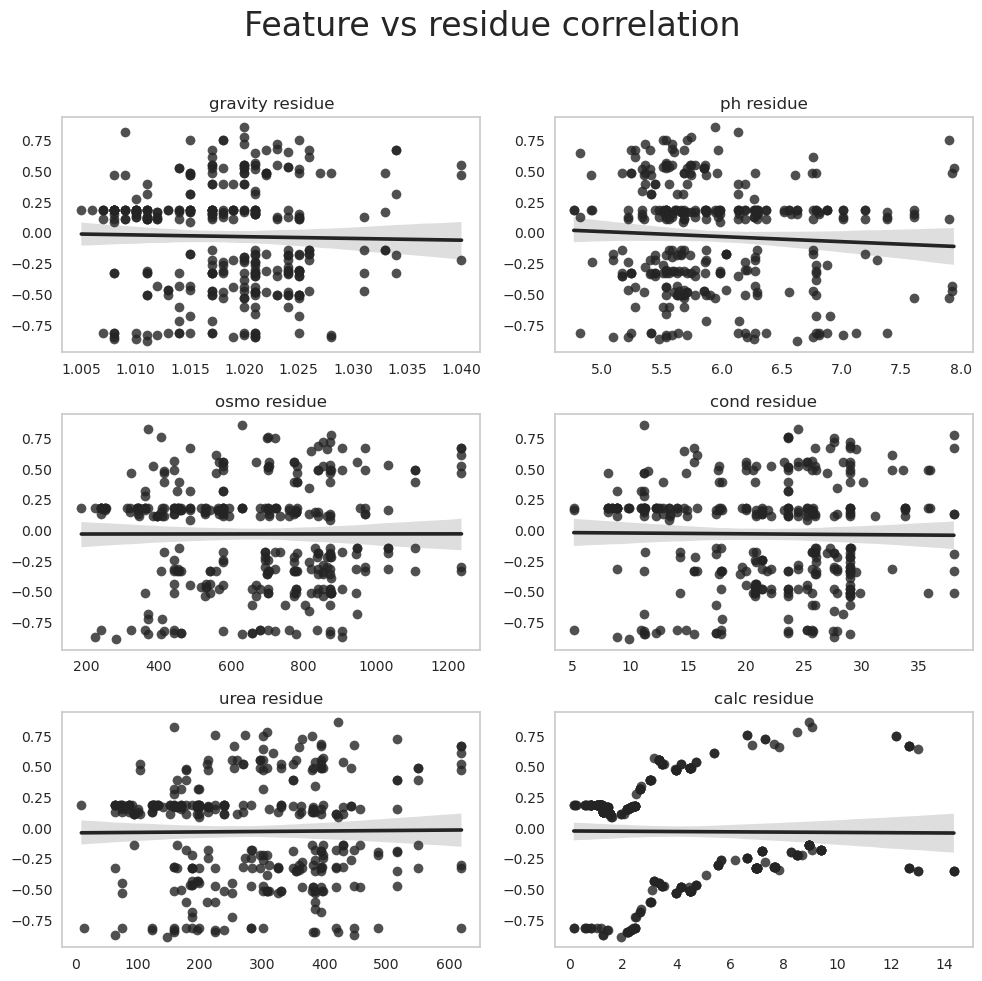

In [18]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))
ax = ax.flatten()

for i, col in enumerate(['gravity', 'ph', 'osmo', 'cond', 'urea', 'calc']):
    sns.regplot(data = X_train, x = col, y = 'calc_residue',
                   ax = ax[i])
    ax[i].set_title(f'{col} residue')
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
    ax[i].grid(False)
    
fig.suptitle('Feature vs residue correlation\n', fontsize = 24)
plt.tight_layout()
plt.show()

The regression plots are not promising, there is no linear correlation between the features and the residual, which suggests that it is very unlikely that the prediction errors can be corrected by the variables.

### Residue mean

The residue of the predictions made from the single variable 'calc' has an average of approximately 17% of the target mean. This indicates that the model based solely on 'calc' is consistently overestimating the target value by 17%, which suggests that 17% of the target outcome cannot be explained by the model.

CHATGPT:

> A zero-mean residual is generally desirable in machine learning. A zero-mean residual indicates that the model's predictions are, on average, just as accurate as the actual values, and that any errors are symmetrically distributed around the actual values. This suggests that the model has managed to capture the underlying patterns in the data and has generalized the problem well. In contrast, if the residuals have a non-zero mean, it indicates that the model is systematically over- or under-predicting the target variable, which suggests that there is bias in the model.

In [19]:
X_test['calc_residue'].mean()/y_test.mean()

0.17115158233579292

# Fitting the residue

As expected all the regression machine learning models performed very poorly in the problem of fitting the calc residue using the other features as input.

Such result indicates that it is improbable that the other variables are capable of adding any significant predictive power to the proposed model.

However, it does not imply that the other features are entirely useless. It suggests that once an inference is made using solely calc, it is unlikely that any other variable will provide significant improvement to it. 

**Remembering: residue fitting is the core principle of boosting models such as LightGBM, CatBoost and XGBoost.**

In [20]:
reg_setup = pc.setup(X_train[['gravity', 'ph', 'osmo', 'cond', 'urea', 'calc_residue']], 
                     target='calc_residue', session_id=123, train_size = .999)

best_model = pc.compare_models(fold=10, round=4)

,Description,Value
0,Session id,123
1,Target,calc_residue
2,Target type,Regression
3,Original data shape,"(331, 6)"
4,Transformed data shape,"(331, 6)"
5,Transformed train set shape,"(330, 6)"
6,Transformed test set shape,"(1, 6)"
7,Numeric features,5
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
llar,Lasso Least Angle Regression,0.3698,0.1831,0.4266,-0.0098,0.3087,1.0502,0.0270
dummy,Dummy Regressor,0.3698,0.1831,0.4266,-0.0098,0.3087,1.0502,0.0480
lasso,Lasso Regression,0.3699,0.1836,0.4271,-0.0121,0.3091,1.0484,0.0250
en,Elastic Net,0.3706,0.1841,0.4276,-0.0146,0.3093,1.0518,0.0260
omp,Orthogonal Matching Pursuit,0.3721,0.1845,0.4280,-0.0165,0.3084,1.0666,0.0270
br,Bayesian Ridge,0.3711,0.1847,0.4283,-0.0178,0.3096,1.0546,0.0280
ridge,Ridge Regression,0.3724,0.1863,0.4301,-0.0257,0.3070,1.0650,0.0300
lr,Linear Regression,0.3698,0.1867,0.4304,-0.0268,0.3043,1.0455,0.4450
lar,Least Angle Regression,0.3698,0.1867,0.4304,-0.0268,0.3043,1.0455,0.0300
huber,Huber Regressor,0.3644,0.1892,0.4329,-0.0376,0.2958,1.0020,0.0370


Processing:   0%|          | 0/85 [00:00<?, ?it/s]